# Retweet/Quote Analysis

This notebook deals with the questions around how the retweet/quote is used among the politicians.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Variable to select the date range from which on the tweets should be considered
# When Original Tweet was created
date_parameter_tweet_selection = pd.to_datetime('2021-08-30') # Voting: '2021-09-26', Official Start: '2021-10-26'

In [4]:
user_friendships_evaluation = pd.read_csv('../data/processed/user_friendships_evaluation.csv', sep=";", na_values="", dtype={'source_id': str, 'target_id': str})
user_list = pd.read_csv('../data/processed/user_list.csv', sep=";", na_values="", dtype={'twitter_id': str})
mdb_list = pd.read_csv('../data/processed/mdb_list.csv', sep=";", na_values="")

retweet_list = pd.read_csv('../data/processed/retweet_list.csv', sep=";", na_values="", lineterminator='\n')
quote_list = pd.read_csv('../data/processed/quote_list.csv', sep=";", na_values="", lineterminator='\n')

In [5]:
user_list['twitter_id'] = pd.to_numeric(user_list['twitter_id'])

mdb_list['fraktion_short'] = mdb_list['fraktion']
mdb_list['fraktion_short'][mdb_list['fraktion'] == 'Alternative für Deutschland'] = 'AfD'
mdb_list['fraktion_short'][mdb_list['fraktion'] == 'Fraktion BÜNDNIS 90/DIE GRÜNEN'] = 'Grünen'
mdb_list['fraktion_short'][mdb_list['fraktion'] == 'Fraktion DIE LINKE.'] = 'Linke'
mdb_list['fraktion_short'][mdb_list['fraktion'] == 'Fraktion der Christlich Demokratischen Union/Christlich - Sozialen Union'] = 'CDU'
mdb_list['fraktion_short'][mdb_list['fraktion'] == 'Fraktion der Freien Demokratischen Partei'] = 'FDP'
mdb_list['fraktion_short'][mdb_list['fraktion'] == 'Fraktion der Sozialdemokratischen Partei Deutschlands'] = 'SPD'

### RETWEETS ###

# Merge follow and tie information into table
retweet_list_enriched = pd.merge(retweet_list, user_friendships_evaluation, how='left', left_on=['retweeter_twitter_handle', 'author_twitter_handle'], right_on=['source_screen_name', 'target_screen_name'])
retweet_list_enriched = pd.merge(retweet_list_enriched, user_friendships_evaluation, how='left', left_on=['retweeter_twitter_handle', 'author_twitter_handle'], right_on=['target_screen_name', 'source_screen_name'])

# Filter retweets based on creation of the orignal tweet
retweet_list_enriched['tweet_created_at'] = pd.to_datetime(retweet_list_enriched['tweet_created_at']).dt.date
retweet_list_enriched = retweet_list_enriched[retweet_list_enriched['tweet_created_at'] > date_parameter_tweet_selection]

# Merge mergeable columns 
retweet_list_enriched['tie_type_x'].update(retweet_list_enriched.pop('tie_type_y'))
retweet_list_enriched['source_follows_target_x'].update(retweet_list_enriched.pop('target_follows_source_y'))
retweet_list_enriched['target_follows_source_x'].update(retweet_list_enriched.pop('source_follows_target_y'))

# Fill info for same person or not available
retweet_list_enriched['tie_type_x'][retweet_list_enriched['retweeter_twitter_handle'] == retweet_list_enriched['author_twitter_handle']] = 'same person' 
retweet_list_enriched['tie_type_x'][retweet_list_enriched['tie_type_x'].isna()] = 'not available'

# Drop empty columns
retweet_list_enriched.drop(['source_screen_name_x', 'target_screen_name_x', 'source_id_x', 'target_id_x', 'source_screen_name_y', 'source_id_y', 'target_screen_name_y', 'target_id_y', 'tweet_referenced_tweet_type_x'], axis=1, inplace=True)

# Add the account information from user_list to the retweets
retweet_list_enriched = pd.merge(retweet_list_enriched, user_list, left_on='retweeter_twitter_handle', right_on='twitter_handle')
retweet_list_enriched = pd.merge(retweet_list_enriched, user_list, left_on='author_twitter_handle', right_on='twitter_handle')
retweet_list_enriched.columns = retweet_list_enriched.columns.str.replace('_x', '_retweeter')
retweet_list_enriched.columns = retweet_list_enriched.columns.str.replace('_y', '_author')

# merge mdb_list
retweet_list_enriched = pd.merge(retweet_list_enriched, mdb_list, left_on='bundestag_id_retweeter', right_on='bundestag_id')
retweet_list_enriched = pd.merge(retweet_list_enriched, mdb_list, left_on='bundestag_id_author', right_on='bundestag_id')
retweet_list_enriched.columns = retweet_list_enriched.columns.str.replace('_x', '_retweeter')
retweet_list_enriched.columns = retweet_list_enriched.columns.str.replace('_y', '_author')

retweet_list_enriched.rename(columns={"source_follows_target_retweeter": "retweeter_follows_author", "target_follows_source_retweeter": "author_follows_retweeter" }, inplace=True)


### QUOTES ###

# Merge follow and tie information into table
quote_list_enriched = pd.merge(quote_list, user_friendships_evaluation, how='left', left_on=['quoter_twitter_handle', 'author_twitter_handle'], right_on=['source_screen_name', 'target_screen_name'])
quote_list_enriched = pd.merge(quote_list_enriched, user_friendships_evaluation, how='left', left_on=['quoter_twitter_handle', 'author_twitter_handle'], right_on=['target_screen_name', 'source_screen_name'])

# Filter retweets based on creation of the orignal tweet
quote_list_enriched['tweet_created_at'] = pd.to_datetime(quote_list_enriched['tweet_created_at']).dt.date
quote_list_enriched = quote_list_enriched[quote_list_enriched['tweet_created_at'] > date_parameter_tweet_selection]

# Merge mergeable columns 
quote_list_enriched['tie_type_x'].update(quote_list_enriched.pop('tie_type_y'))
quote_list_enriched['source_follows_target_x'].update(quote_list_enriched.pop('target_follows_source_y'))
quote_list_enriched['target_follows_source_x'].update(quote_list_enriched.pop('source_follows_target_y'))

# Fill info for same person or not available
quote_list_enriched['tie_type_x'][quote_list_enriched['quoter_twitter_handle'] == quote_list_enriched['author_twitter_handle']] = 'same person' 
quote_list_enriched['tie_type_x'][quote_list_enriched['tie_type_x'].isna()] = 'not available'

# Drop empty columns
quote_list_enriched.drop(['source_screen_name_x', 'target_screen_name_x', 'source_id_x', 'target_id_x', 'source_screen_name_y', 'source_id_y', 'target_screen_name_y', 'target_id_y', 'tweet_referenced_tweet_type_x'], axis=1, inplace=True)

# Add the account information from user_list to the quotes
quote_list_enriched = pd.merge(quote_list_enriched, user_list, left_on='quoter_twitter_handle', right_on='twitter_handle')
quote_list_enriched = pd.merge(quote_list_enriched, user_list, left_on='author_twitter_handle', right_on='twitter_handle')
quote_list_enriched.columns = quote_list_enriched.columns.str.replace('_x', '_quoter')
quote_list_enriched.columns = quote_list_enriched.columns.str.replace('_y', '_author')

# merge mdb_list
quote_list_enriched = pd.merge(quote_list_enriched, mdb_list, left_on='bundestag_id_quoter', right_on='bundestag_id')
quote_list_enriched = pd.merge(quote_list_enriched, mdb_list, left_on='bundestag_id_author', right_on='bundestag_id')
quote_list_enriched.columns = quote_list_enriched.columns.str.replace('_x', '_quoter')
quote_list_enriched.columns = quote_list_enriched.columns.str.replace('_y', '_author')

quote_list_enriched.rename(columns={"source_follows_target_quoter": "quoter_follows_author", "target_follows_source_quoter": "author_follows_q" }, inplace=True)

display(retweet_list_enriched[retweet_list_enriched['retweeter_twitter_handle'] == 'SaskiaLeaRaquel'])

/var/folders/bh/vwy58769197gtfy7_tb12xqw0000gn/T/ipykernel_52571/3005914012.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdb_list['fraktion_short'][mdb_list['fraktion'] == 'Alternative für Deutschland'] = 'AfD'
/var/folders/bh/vwy58769197gtfy7_tb12xqw0000gn/T/ipykernel_52571/3005914012.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdb_list['fraktion_short'][mdb_list['fraktion'] == 'Fraktion BÜNDNIS 90/DIE GRÜNEN'] = 'Grünen'
/var/folders/bh/vwy58769197gtfy7_tb12xqw0000gn/T/ipykernel_52571/3005914012.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

,retweeter_twitter_handle,retweet_tweet_id,retweet_text,retweeter_twitter_id,retweet_created_at,author_twitter_handle,tweet_id,tweet_text,author_twitter_id,tweet_created_at,...,mdbwp_bis_author,wkr_nummer_author,wkr_name_author,wkr_land_author,liste_author,mandatsart_author,fraktion_author,ministerium_author,fkt_lang_author,fraktion_short_author
341,SaskiaLeaRaquel,1473936748044603394,RT @IreneMihalic: Querdenker tragen ihren Hass...,574285449,2021-12-23,IreneMihalic,1473915352463642624,Querdenker tragen ihren Hass auf die Straße. E...,143000381,2021-12-23,...,NaN,NaN,NaN,NaN,NW,Landesliste,Fraktion BÜNDNIS 90/DIE GRÜNEN,NaN,NaN,Grünen


### 1. What is the social tie between author and retweeter/quoter?

In [6]:
#### RETWEETS ####

# Create data frame with the results
retweet_social_ties = pd.DataFrame(columns=['tie_type', 'retweet_count'])
retweet_social_ties.loc[len(retweet_social_ties.index)] = ['weak', retweet_list_enriched[retweet_list_enriched['tie_type_retweeter'] == 'weak'].shape[0]]
retweet_social_ties.loc[len(retweet_social_ties.index)] = ['strong', retweet_list_enriched[retweet_list_enriched['tie_type_retweeter'] == 'strong'].shape[0]]
retweet_social_ties.loc[len(retweet_social_ties.index)] = ['no tie', retweet_list_enriched[retweet_list_enriched['tie_type_retweeter'] == 'no tie'].shape[0]]
retweet_social_ties.loc[len(retweet_social_ties.index)] = ['same person', retweet_list_enriched[retweet_list_enriched['tie_type_retweeter'] == 'same person'].shape[0]]
retweet_social_ties.loc[len(retweet_social_ties.index)] = ['not available', retweet_list_enriched[retweet_list_enriched['tie_type_retweeter'] == 'not available'].shape[0]]

# Add a calculated percentage column
retweet_social_ties['retweet_count_percentage'] = round(retweet_social_ties.retweet_count / retweet_social_ties.retweet_count.sum() * 100, 1)

display(retweet_social_ties)

,tie_type,retweet_count,retweet_count_percentage
0,weak,601,16.7
1,strong,2806,77.8
2,no tie,94,2.6
3,same person,108,3.0
4,not available,0,0.0


In [7]:
#### QUOTES ####

# Create data frame with the results
quote_social_ties = pd.DataFrame(columns=['tie_type', 'quote_count'])
quote_social_ties.loc[len(quote_social_ties.index)] = ['weak', quote_list_enriched[quote_list_enriched['tie_type_quoter'] == 'weak'].shape[0]]
quote_social_ties.loc[len(quote_social_ties.index)] = ['strong', quote_list_enriched[quote_list_enriched['tie_type_quoter'] == 'strong'].shape[0]]
quote_social_ties.loc[len(quote_social_ties.index)] = ['no tie', quote_list_enriched[quote_list_enriched['tie_type_quoter'] == 'no tie'].shape[0]]
quote_social_ties.loc[len(quote_social_ties.index)] = ['same person', quote_list_enriched[quote_list_enriched['tie_type_quoter'] == 'same person'].shape[0]]
quote_social_ties.loc[len(quote_social_ties.index)] = ['not available', quote_list_enriched[quote_list_enriched['tie_type_quoter'] == 'not available'].shape[0]]

quote_social_ties['quote_count_percentage'] = round(quote_social_ties.quote_count / quote_social_ties.quote_count.sum() * 100, 1)
display(quote_social_ties)

,tie_type,quote_count,quote_count_percentage
0,weak,146,18.8
1,strong,381,49.1
2,no tie,81,10.4
3,same person,168,21.6
4,not available,0,0.0


### 2. How do the fractions retweet from each other?

tweet_id                                            \
fraktion_short_author         AfD    CDU    FDP Fraktionslos  Grünen  Linke   
fraktion_short_retweeter                                                      
AfD                         203.0    1.0    NaN          NaN     NaN    3.0   
CDU                           NaN  634.0   26.0          1.0     8.0    NaN   
FDP                           NaN    3.0  660.0          NaN    16.0    1.0   
Fraktionslos                  1.0    NaN    NaN          NaN     1.0    NaN   
Grünen                        NaN    2.0   14.0          2.0  1004.0    2.0   
Linke                         NaN    NaN    NaN          NaN     6.0  228.0   
SPD                           NaN    4.0   20.0          NaN    37.0    2.0   

                                 
fraktion_short_author       SPD  
fraktion_short_retweeter         
AfD                         1.0  
CDU                         7.0  
FDP                        20.0  
Fraktionslos                NaN  
Grünen                     25.0  
Linke                       3.0  
SPD                       566.0

,tie_type_retweeter,AfD,CDU,FDP,Fraktionslos,Grünen,Linke,SPD
0,no tie,2.0,25.0,18.0,2.0,13.0,6.0,28.0
1,strong,171.0,539.0,624.0,1.0,896.0,187.0,388.0
2,weak,31.0,80.0,78.0,NaN,163.0,43.0,206.0


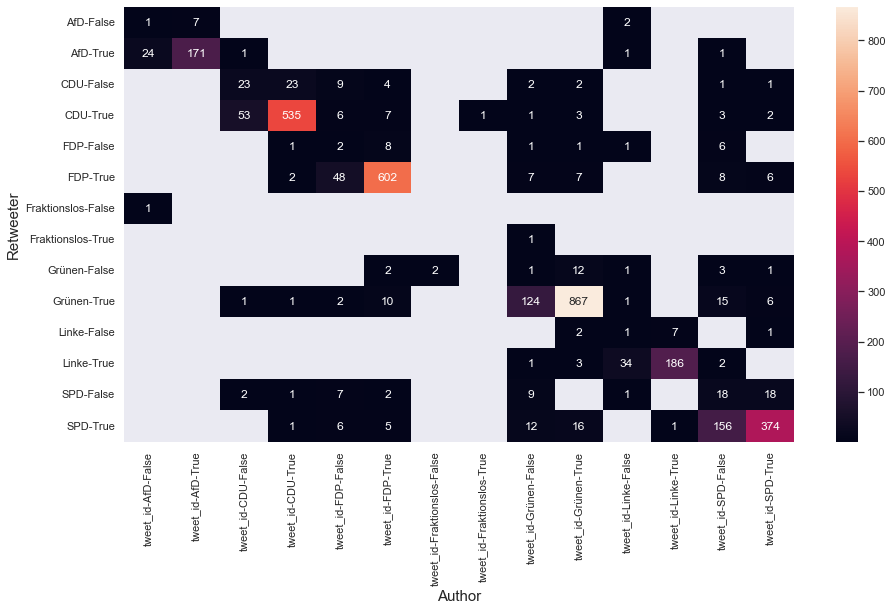

In [8]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# filter out self-loops
retweet_list_enriched = retweet_list_enriched[(retweet_list_enriched['retweeter_twitter_handle'] != retweet_list_enriched['author_twitter_handle'])]

retweet_pivot = pd.pivot_table(retweet_list_enriched, index=['fraktion_short_retweeter'], columns=['fraktion_short_author'], values=['tweet_id'], aggfunc='count')
display(retweet_pivot)

retweet_pivot = pd.pivot_table(retweet_list_enriched, index=['fraktion_short_retweeter', 'retweeter_follows_author'], columns=['fraktion_short_author', 'author_follows_retweeter'], values=['tweet_id'], aggfunc='count')

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(retweet_pivot, annot=True, fmt='.4g')
plt.xlabel('Author', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Retweeter', fontsize = 15) # x-axis label with fontsize 15

same_fraction_pivot = pd.pivot_table(retweet_list_enriched, index=['tie_type_retweeter'], columns=['fraktion_short_author'], values=['fraktion_short_retweeter'], aggfunc='count')
same_fraction_pivot = same_fraction_pivot.droplevel(0, axis=1).rename_axis(None, axis=1).reset_index()
display(same_fraction_pivot)

tweet_id                               
fraktion_short_author      AfD   CDU   FDP Grünen Linke   SPD
fraktion_short_quoter                                        
AfD                        8.0   3.0   6.0    6.0   NaN   5.0
CDU                        1.0  58.0  23.0   24.0   2.0  32.0
FDP                        1.0   9.0  85.0   10.0   1.0  12.0
Grünen                     NaN   9.0   7.0  168.0   2.0  15.0
Linke                      NaN   3.0   4.0    3.0  15.0   8.0
SPD                        NaN   4.0   5.0    8.0   1.0  70.0

Index(['quoter_twitter_handle', 'quote_tweet_id', 'quote_text',
       'quoter_twitter_id ', 'quote_created_at', 'author_twitter_handle',
       'tweet_id', 'tweet_text', 'author_twitter_id', 'tweet_created_at',
       'quoter_follows_author', 'author_follows_q', 'tie_type_quoter',
       'bundestag_id_quoter', 'nachname_quoter', 'vorname_quoter', 'wp_quoter',
       'fraktion_quoter', 'twitter_handle_quoter', 'account_type_quoter',
       'twitter_id_quoter', 'twitter_name_quoter', 'created_at_quoter',
       'description_quoter', 'location_quoter', 'protected_quoter',
       'followers_count_quoter', 'following_count_quoter',
       'tweet_count_quoter', 'listed_count_quoter', 'verified_quoter',
       'api_call_quoter', 'bundestag_id_author', 'nachname_author',
       'vorname_author', 'wp_author', 'fraktion_author',
       'twitter_handle_author', 'account_type_author', 'twitter_id_author',
       'twitter_name_author', 'created_at_author', 'description_author',
       'location_au

,tie_type_retweeter,AfD,CDU,FDP,Fraktionslos,Grünen,Linke,SPD
0,no tie,2.0,25.0,18.0,2.0,13.0,6.0,28.0
1,strong,171.0,539.0,624.0,1.0,896.0,187.0,388.0
2,weak,31.0,80.0,78.0,NaN,163.0,43.0,206.0


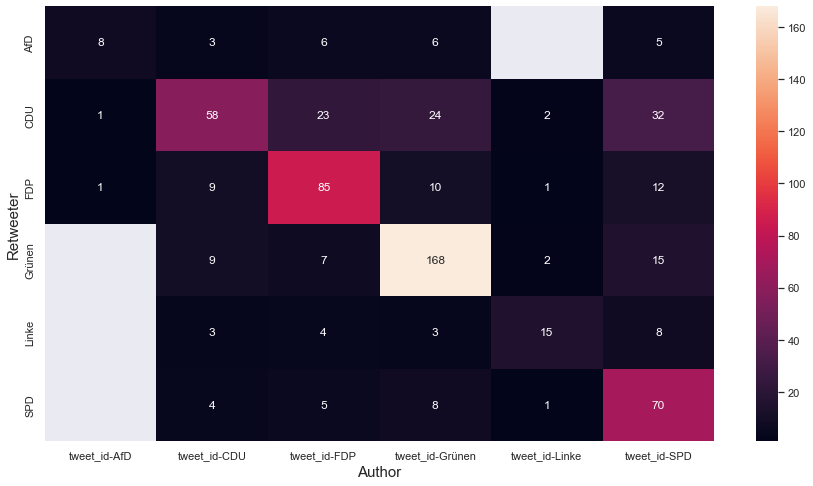

In [23]:
# filter out self-loops
quote_list_enriched = quote_list_enriched[(quote_list_enriched['quoter_twitter_handle'] != quote_list_enriched['author_twitter_handle'])]

quote_pivot = pd.pivot_table(quote_list_enriched, index=['fraktion_short_quoter'], columns=['fraktion_short_author'], values=['tweet_id'], aggfunc='count')
display(quote_pivot)
display(quote_list_enriched.columns)
# quote_pivot = pd.pivot_table(quote_list_enriched, index=['author_follows_q', 'quoter_follows_author'], columns=['fraktion_short_author', 'author_follows_q'], values=['tweet_id'], aggfunc='count')

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(quote_pivot, annot=True, fmt='.4g')
plt.xlabel('Author', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Retweeter', fontsize = 15) # x-axis label with fontsize 15

quote_same_fraction_pivot = pd.pivot_table(retweet_list_enriched, index=['tie_type_retweeter'], columns=['fraktion_short_author'], values=['fraktion_short_retweeter'], aggfunc='count')
quote_same_fraction_pivot = quote_same_fraction_pivot.droplevel(0, axis=1).rename_axis(None, axis=1).reset_index()
display(quote_same_fraction_pivot)

### 3. Is there a correlation between In-Degree (Number of Retweets in this sample) and Followers-Count?

In [ ]:
# Weighted In-Degree
groupby1 = retweet_list_enriched.groupby(by='author_twitter_handle').count()
display(groupby1.sort_values(by='retweet_tweet_id', ascending=False))

in_degree_followers = retweet_list_enriched[['author_twitter_handle', 'followers_count_author', 'fraktion_author']]
in_degree_followers.drop_duplicates(inplace=True)
in_degree_followers = pd.merge(in_degree_followers, groupby1, on="author_twitter_handle")
# in_degree_followers = in_degree_followers.droplevel(0, axis=1).rename_axis(None, axis=1).reset_index()

# sns.regplot(data=in_degree_followers, x="followers_count_author", y="retweeter_twitter_handle")


display(in_degree_followers)

# Weighted Out-Degree
groupby2 = retweet_list_enriched.groupby(by='retweeter_twitter_handle').count()
display(groupby2.sort_values(by='retweet_tweet_id', ascending=False))

In [ ]:
in_degree = sns.displot(groupby1, x="retweeter_twitter_handle")

In [ ]:
out_degree = sns.displot(groupby2, x="retweeter_twitter_handle")

In [ ]:
followers_count_reg_plot = sns.regplot(x="retweeter_twitter_handle", y="followers_count_author_x", data=in_degree_followers)

In [ ]:
# check how tweets (content) differ that were only retweeted by one party/fraction